In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [2]:
trainDF = pd.read_csv('train.csv')
print(trainDF.info())
trainDF.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
701,702,1,1,"Silverthorne, Mr. Spencer Victor",male,35.0,0,0,PC 17475,26.2875,E24,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.5500,NaN,S
372,373,0,3,"Beavan, Mr. William Thomas",male,19.0,0,0,323951,8.0500,NaN,S


In [3]:
testDF = pd.read_csv('test.csv')
print(testDF.info())
testDF.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
259,1151,3,"Midtsjo, Mr. Karl Albert",male,21.0,0,0,345501,7.7750,NaN,S
323,1215,1,"Rowe, Mr. Alfred G",male,33.0,0,0,113790,26.5500,NaN,S
146,1038,1,"Hilliard, Mr. Herbert Henry",male,NaN,0,0,17463,51.8625,E46,S


In [4]:
concatDF = pd.concat([trainDF,testDF])
concatDF = concatDF.reset_index(drop=True)
pd.get_dummies(concatDF,columns=['Sex','Embarked']).drop(columns=['PassengerId','Name','Ticket','Cabin']).corr()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.543351,-0.543351,0.168240,0.003650,-0.155660
Pclass,-0.338481,1.000000,-0.408106,0.060832,0.018322,-0.558629,-0.124617,0.124617,-0.269658,0.230491,0.096335
Age,-0.077221,-0.408106,1.000000,-0.243699,-0.150917,0.178740,-0.063645,0.063645,0.085777,-0.019458,-0.075972
SibSp,-0.035322,0.060832,-0.243699,1.000000,0.373587,0.160238,0.109609,-0.109609,-0.048396,-0.048678,0.075198
Parch,0.081629,0.018322,-0.150917,0.373587,1.000000,0.221539,0.213125,-0.213125,-0.008635,-0.100943,0.073258
Fare,0.257307,-0.558629,0.178740,0.160238,0.221539,1.000000,0.185523,-0.185523,0.286269,-0.130059,-0.172683
Sex_female,0.543351,-0.124617,-0.063645,0.109609,0.213125,0.185523,1.000000,-1.000000,0.066564,0.088651,-0.119504
Sex_male,-0.543351,0.124617,0.063645,-0.109609,-0.213125,-0.185523,-1.000000,1.000000,-0.066564,-0.088651,0.119504
Embarked_C,0.168240,-0.269658,0.085777,-0.048396,-0.008635,0.286269,0.066564,-0.066564,1.000000,-0.164166,-0.775441
Embarked_Q,0.003650,0.230491,-0.019458,-0.048678,-0.100943,-0.130059,0.088651,-0.088651,-0.164166,1.000000,-0.489874


In [5]:
featuredDF = pd.read_csv('train3.csv')
featuredDF = pd.get_dummies(featuredDF,columns=['Sex','Embarked','Pclass'])
featuredDF = featuredDF.drop(columns=['Ticket','Cabin'])
featuredDF['Age'] = featuredDF['Age']/featuredDF['Age'].max()
featuredDF['Fare'] = featuredDF['Fare']/featuredDF['Fare'].max()
featuredDF['SibSp'] = featuredDF['SibSp']/featuredDF['SibSp'].max()
featuredDF['Parch'] = featuredDF['Parch']/featuredDF['Parch'].max()
featuredDF = featuredDF.astype(float)
featuredDF[:891]

,PassengerId,Survived,Age,SibSp,Parch,Fare,Name,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1.0,0.0,0.2750,0.125,0.000000,0.014151,0.156673,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,2.0,1.0,0.4750,0.125,0.000000,0.139136,0.782000,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3.0,1.0,0.3250,0.000,0.000000,0.015469,0.697802,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,4.0,1.0,0.4375,0.125,0.000000,0.103644,0.782000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,5.0,0.0,0.4375,0.000,0.000000,0.015713,0.156673,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887.0,0.0,0.3375,0.000,0.000000,0.025374,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
887,888.0,1.0,0.2375,0.000,0.000000,0.058556,0.697802,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
888,889.0,0.0,0.3000,0.125,0.222222,0.045771,0.697802,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
889,890.0,1.0,0.3250,0.000,0.000000,0.058556,0.156673,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [6]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, DF:pd.DataFrame):
        self.PassengerId= DF['PassengerId'].values
        self.Servived = pd.get_dummies(DF['Survived']).values
        DF = DF.drop(columns=['PassengerId','Survived'])
        self.data = DF.astype(float).values
        pass

    def __len__(self):
        return len(self.PassengerId)

    def __getitem__(self, idx):

        x = torch.FloatTensor(self.data[idx])
        y = torch.FloatTensor(self.Servived[idx])
        return x, y


dataSet = MyDataset(DF=featuredDF[:891])
testSet = MyDataset(DF=featuredDF[891:])
dataSet[0]

(tensor([0.2750, 0.1250, 0.0000, 0.0142, 0.1567, 0.0000, 1.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000, 1.0000]),
 tensor([1., 0.]))

In [7]:

trainSet, valSet = torch.utils.data.random_split(dataSet,(0.8,0.2))

In [8]:
trainLoader= torch.utils.data.DataLoader(trainSet,batch_size=2048,sampler=torch.utils.data.RandomSampler(trainSet))
valLoader= torch.utils.data.DataLoader(valSet,batch_size=2048,sampler=torch.utils.data.RandomSampler(valSet))
testLoader = torch.utils.data.DataLoader(testSet,batch_size=2048)
next(iter(trainLoader))

[tensor([[0.3375, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
         [0.2375, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
         [0.3000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
         ...,
         [0.2625, 0.2500, 0.2222,  ..., 1.0000, 0.0000, 0.0000],
         [0.4375, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
         [0.2000, 0.1250, 0.3333,  ..., 0.0000, 0.0000, 1.0000]]),
 tensor([[0., 1.],
         [0., 1.],
         [0., 1.],
         ...,
         [0., 1.],
         [1., 0.],
         [1., 0.]])]

In [9]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(13, 6),
            torch.nn.ReLU(),
            torch.nn.Linear(6, 6),
            torch.nn.ReLU(),
            torch.nn.Linear(6, 2)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using mps device
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=13, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=6, bias=True)
    (3): ReLU()
    (4): Linear(in_features=6, out_features=2, bias=True)
  )
)


In [10]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters())

cnt: 0 - valLoss: 0.6800490617752075 - trainLoss: 0.6823776960372925
cnt: 0 - valLoss: 0.6799888014793396 - trainLoss: 0.6823043823242188
cnt: 0 - valLoss: 0.6799285411834717 - trainLoss: 0.6822311878204346
cnt: 0 - valLoss: 0.6798684597015381 - trainLoss: 0.6821579933166504
cnt: 0 - valLoss: 0.6798084378242493 - trainLoss: 0.6820847988128662
cnt: 0 - valLoss: 0.6797484755516052 - trainLoss: 0.6820117831230164
cnt: 0 - valLoss: 0.6796885132789612 - trainLoss: 0.6819389462471008
cnt: 0 - valLoss: 0.6796286702156067 - trainLoss: 0.6818661093711853
cnt: 0 - valLoss: 0.679568886756897 - trainLoss: 0.6817933320999146
cnt: 0 - valLoss: 0.6795092225074768 - trainLoss: 0.6817207336425781
cnt: 0 - valLoss: 0.6794496774673462 - trainLoss: 0.6816481351852417
cnt: 0 - valLoss: 0.6793901920318604 - trainLoss: 0.6815757751464844
cnt: 0 - valLoss: 0.6793308854103088 - trainLoss: 0.681503415107727
cnt: 0 - valLoss: 0.6792716383934021 - trainLoss: 0.6814311742782593
cnt: 0 - valLoss: 0.6792125105857849

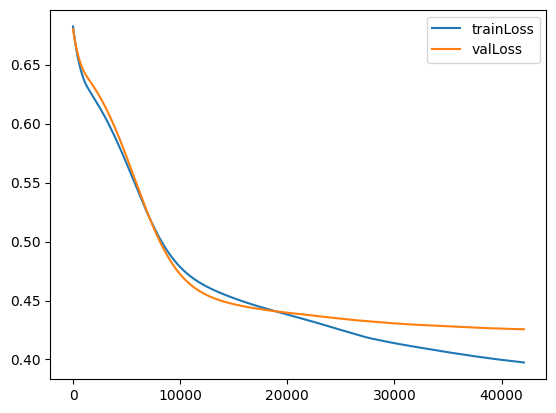

In [11]:
def trainAI(dataloader, model, loss_fn, optimizer):
    model.train()
    trainLoss=0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        trainLoss +=loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return trainLoss

def valAI(dataloader, model, loss_fn):
    model.eval()
    valLoss =0
    with torch.no_grad():
        for X ,y  in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            # for i in loss:
            valLoss+= loss.item()
    return valLoss

trainLoss=[]
valLoss=[]
bestModel = model
bestLoss = float('inf')
cnt=0

while(cnt<100):
    trainLoss.append(trainAI(trainLoader, model, loss_fn, optimizer))
    valLoss.append(valAI(valLoader, model, loss_fn))

    print(f'cnt: {cnt} - valLoss: {valLoss[-1]} - trainLoss: {trainLoss[-1]}')
    if bestLoss<valLoss[-1]:
        cnt+=1
    else:
        cnt = 0
        bestLoss = valLoss[-1]
        bestModel = model

plt.plot(trainLoss,label='trainLoss')
plt.plot(valLoss,label='valLoss')
plt.legend()

In [12]:
def testAI(dataloader, model):
    model.eval()
    result = []
    y=892
    with torch.no_grad():
        for X ,_  in dataloader:
            X  = X.to(device)
            pred = model(X)
            for i in pred:
                result.append([y,torch.argmax(i).item()])
                y+=1
    return result

result = testAI(testLoader, bestModel)
result = pd.DataFrame(result)
result = result.astype(int)
result.columns=['passengerId','Survived']
result

,passengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [13]:
result.to_csv('result.csv',index=False)